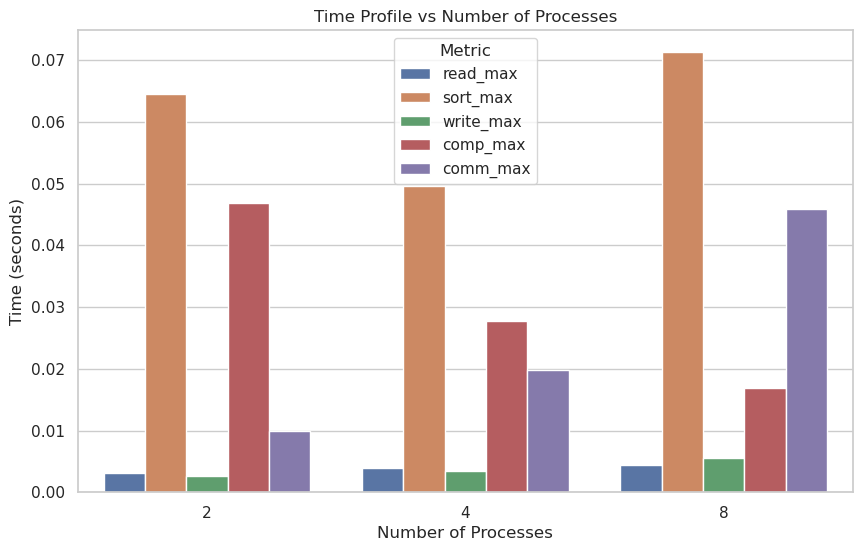

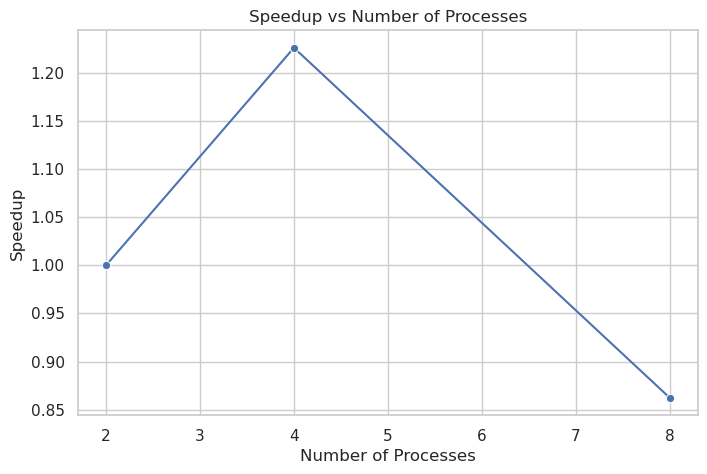

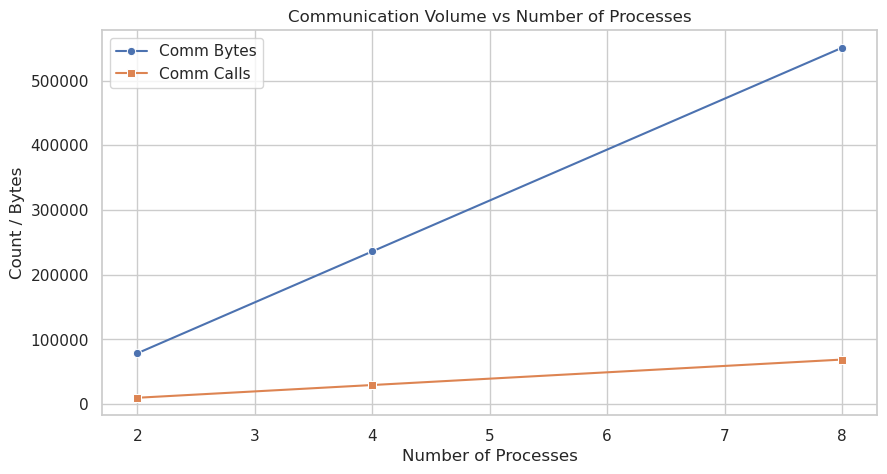

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取 CSV
df = pd.read_csv("/home/allenzhuang0117/Parallel-Computing/hw1/metrics.csv")

# 設定美觀
sns.set(style="whitegrid")

# 1. Time Profile：讀檔 / 排序 / 寫檔 / 計算 / 通訊
plt.figure(figsize=(10,6))
df_time = df[['size','read_max','sort_max','write_max','comp_max','comm_max']]
df_time_melted = df_time.melt(id_vars='size', var_name='Metric', value_name='Time(s)')
sns.barplot(x='size', y='Time(s)', hue='Metric', data=df_time_melted)
plt.title("Time Profile vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Time (seconds)")
plt.legend(title='Metric')
plt.show()

# 2. Speedup：以單一 process 為 baseline（假設最少 size 對應 baseline）
baseline_total = df['total_max'].iloc[0]
df['Speedup'] = baseline_total / df['total_max']

plt.figure(figsize=(8,5))
sns.lineplot(x='size', y='Speedup', marker='o', data=df)
plt.title("Speedup vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Speedup")
plt.show()

# 3. Communication Bytes & Calls
plt.figure(figsize=(10,5))
sns.lineplot(x='size', y='comm_bytes_sum', marker='o', data=df, label="Comm Bytes")
sns.lineplot(x='size', y='comm_calls_sum', marker='s', data=df, label="Comm Calls")
plt.title("Communication Volume vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Count / Bytes")
plt.legend()
plt.show()